# |Modeling - PIX Forecasting| Cross validation / Backtesting evaluation

**Objective**: Generate figures, plots, reports out of the cross validation process.


## 1.0 Imports

In [2]:
import sys
import os

if not os.getcwd().split("\\")[-1] == "ip_forecasting":
    # Get the directory of the current notebook
    notebook_dir = os.path.dirname(
        os.path.abspath("__file__")
    )  # Use __file__ for portability

    # Move up one level to the project root
    project_root = os.path.abspath(os.path.join(notebook_dir, "../.."))

    # Change working directory
    os.chdir(project_root)
print(os.getcwd())

c:\Users\miche\Documents\projects\ip_forecasting\Artefact


In [3]:
import pandas as pd
import numpy as np
import pandas_gbq
from scipy.stats import shapiro
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import mean_absolute_percentage_error

import src.utils.useful_functions as uf
from src.features.feat_eng import fill_na_interpolation
from src.configuration.config_model import model_config, models_params
from src.features.config_feature import variables_list
from src.visualization.config_viz import colors
from src.data.data_loader import load_feature_df
import shap

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

c:\Users\miche\anaconda3\envs\suzano\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
TARGET_COL = model_config["target_col"]
PREDICTED_COL = model_config["predicted_col"]
FORECAST_HORIZON = model_config["forecast_horizon"]
N_SPLITS = model_config["n_windows"]
MODEL_NAME = model_config["model_name"]
USE_TUNED_PARMS = model_config["use_tuned_params"]

if USE_TUNED_PARMS:
    models_list = list(models_params["tuned"].keys())
else:
    models_list = list(models_params["default"].keys())

matplotlib.rcParams.update({"font.size": 15})

## 2.0 Data Loading

In [5]:
feature_df = load_feature_df(
    "features_all_features_weekly_out_updated",
    filter_columns=True,
    columns_to_filter=[*variables_list, TARGET_COL],
)

# Fill intermediary missing values with linear interpolation
feature_df = fill_na_interpolation(feature_df, feature_df.columns)

# Then propagate the first value to the past and the final value to the present, when needed.
for col in feature_df.columns:
    feature_df[col] = feature_df[col].bfill().ffill()

future_forecast = pd.read_csv(
    "./data/output/out-of-sample-forecast_out.csv", parse_dates=["date"]
)

2024-10-15 15:16:42,047 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: [WinError 10051] Uma operação de soquete foi tentada em uma rede inacessível
2024-10-15 15:16:42,996 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 2 of 3. Reason: [WinError 10051] Uma operação de soquete foi tentada em uma rede inacessível
2024-10-15 15:16:45,212 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 3 of 3. Reason: [WinError 10051] Uma operação de soquete foi tentada em uma rede inacessível
Downloading: 100%|██████████|


In [6]:
validation_report_df = pd.read_csv(
    "./data/output/mlflow/validation_report_df_out.csv",
    parse_dates=["date"],
)  # with_pred_exog_5_validation_results


# Lendo os resultados reportados do IP 45D pela Priscila
baseline_results = pd.read_excel("./data/raw/IP45D - Performance Monitor.xlsx")
baseline_results.columns = baseline_results.columns.str.lower()
baseline_results = baseline_results.rename(
    columns={
        "forecast's date": "date",
        "forecast": "FORECAST",
        "pix china bhkp (actual)": "ACTUAL",
    }
)

In [7]:
baseline_results = baseline_results.drop_duplicates(subset=["date"], keep="first")
baseline_results = baseline_results.sort_values("date")

In [8]:
# Removendo os dois ultimos pontos que não temos
# baseline_results = baseline_results.iloc[:-2, :]
baseline_results.loc[96, "ACTUAL"] = 612.83

## 3.0 Pre-processamento das bases

In [9]:
# Removendo os modelos que constantemente performam ruim
validation_report_df = validation_report_df[
    validation_report_df["MODEL_TYPE"].isin(
        ["LGBMRegressor", "XGBRegressor", "CatBoostRegressor"]
    )
]

# Filtrando o validation report para caber no timeframe do IP
validation_report_df = validation_report_df[
    (validation_report_df["date"] >= baseline_results["date"].min())
    # & (validation_report_df["date"] <= baseline_results["date"].max())
]

# Criando um ID de janela para o report baseline
unique_months = sorted(baseline_results["presentation month"].unique())
months_mapping = dict()
iterator = 1
for month in unique_months:
    months_mapping[month] = iterator
    iterator += 1

baseline_results["WINDOW"] = baseline_results["presentation month"].map(months_mapping)

In [10]:
validation_report_df.tail()

,date,ACTUAL,FORECAST,MODEL_TYPE,TRAINING_MAPE,TRAINING_RMSE,MAPE,RMSE,MAE,R2,WAPE,Bias,MAPE_6W,RMSE_6W,CLASS,WINDOW,TRAINING_DATE,REFERENCE_DATE,REFERENCE_PIX
265,2024-09-06,574.40,600.755296,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.022,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83
266,2024-09-13,572.66,604.875533,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.027,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83
267,2024-09-20,571.84,594.178976,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.019,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83
268,2024-09-27,561.50,592.597988,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.027,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83
269,2024-10-04,561.05,596.091143,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.030,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83


## 4.0 Comparando as médias gerais no período todo

In [11]:
def calculate_grouped_mape_bl(group):
    return mean_absolute_percentage_error(group["ACTUAL"], group["FORECAST"])


def calculate_grouped_mape_nm(group):
    return mean_absolute_percentage_error(group["ACTUAL"], group["Ensemble"])

### 4.1 Métricas do modelo Baseline

In [12]:
baseline_results["mape_by_week"] = (
    np.abs(baseline_results["ACTUAL"] - baseline_results["FORECAST"])
    / baseline_results["ACTUAL"]
)

#### 4.1.1 MAPE médio por janela

In [13]:
# Agrupar por coluna categórica e calcular MAPE para cada grupo
mape_by_window_bl = (
    baseline_results.groupby("WINDOW")[["ACTUAL", "FORECAST"]]
    .apply(calculate_grouped_mape_bl)
    .reset_index(name="MAPE")
)
avg_mape_baseline = round(mape_by_window_bl["MAPE"].mean() * 100, 2)
med_mape_baseline = round(mape_by_window_bl["MAPE"].median() * 100, 2)

print(f"MAPE médio do Baseline para todas as {N_SPLITS} janelas: {avg_mape_baseline}%")
print(
    f"MAPE mediano do Baseline para todas as {N_SPLITS} janelas: {med_mape_baseline}%"
)
print(f"Desvio padrão do MAPE: {round(mape_by_window_bl['MAPE'].std()*100, 2)}%")

MAPE médio do Baseline para todas as 15 janelas: 6.13%
MAPE mediano do Baseline para todas as 15 janelas: 3.75%
Desvio padrão do MAPE: 7.29%


In [14]:
baseline_results = baseline_results.merge(mape_by_window_bl, on=["WINDOW"], how="left")

#### 4.1.2 MAPE para a última semana

In [15]:
avg_mape_baseline_last = round(
    baseline_results.groupby("WINDOW").tail(1)["mape_by_week"].mean() * 100, 2
)
std_mape_baseline_last = round(
    baseline_results.groupby("WINDOW").tail(1)["mape_by_week"].std() * 100, 2
)
print(f"MAPE médio do Baseline para a última semana: {avg_mape_baseline_last}%")
print(f"Desvio Padrão do MAPE Baseline para a última semana: {std_mape_baseline_last}%")

MAPE médio do Baseline para a última semana: 8.64%
Desvio Padrão do MAPE Baseline para a última semana: 9.92%


### 4.2 Métricas dos novos modelos

In [16]:
validation_report_df["mape_by_week"] = (
    np.abs(validation_report_df["ACTUAL"] - validation_report_df["FORECAST"])
    / validation_report_df["ACTUAL"]
)

#### 4.2.1 Média para todos os modelos

##### 4.2.1.1 MAPE médio por janela

In [17]:
mean_metrics_by_model = validation_report_df.groupby("MODEL_TYPE", as_index=False).agg(
    {
        "MAPE": ["mean", "median", "std"],
        "RMSE": ["mean", "median", "std"],
    }
)

avg_mean_all_models = round(mean_metrics_by_model["MAPE"]["mean"].mean() * 100, 3)
avg_median_all_models = round(mean_metrics_by_model["MAPE"]["median"].mean() * 100, 2)

print(
    f"MAPE médio médio de todos os modelos para todas as {N_SPLITS} janelas: {avg_mean_all_models}%"
)

print(
    f"MAPE médio mediano de todos os modelos para todas as {N_SPLITS} janelas: {avg_median_all_models}%"
)
print(
    f"Desvio padrão do MAPE: {round(mean_metrics_by_model['MAPE']['mean'].std()*100, 2)}%"
)

# MAPE médio médio de todos os modelos para todas as 17 janelas: 5.39%
# MAPE médio mediano de todos os modelos para todas as 17 janelas: 3.52%
# Desvio padrão do MAPE: 1.16%

# MAPE médio médio de todos os modelos para todas as 17 janelas: 4.326%
# MAPE médio mediano de todos os modelos para todas as 17 janelas: 2.71%
# Desvio padrão do MAPE: 0.24%

MAPE médio médio de todos os modelos para todas as 15 janelas: 4.77%
MAPE médio mediano de todos os modelos para todas as 15 janelas: 3.18%
Desvio padrão do MAPE: 0.67%


##### 4.2.1.2 MAPE para a última semana

In [18]:
avg_mean_all_models_last = round(
    validation_report_df.groupby("WINDOW").tail(1)["mape_by_week"].mean() * 100, 2
)
std_mean_all_models = round(
    validation_report_df.groupby("WINDOW").tail(1)["mape_by_week"].std() * 100, 2
)
print(
    f"MAPE médio de todos os modelos para a última semana: {avg_mean_all_models_last}%"
)
print(
    f"Desvio Padrão do MAPE todos os modelos para a última semana: {std_mean_all_models}%"
)

# MAPE médio do Baseline para a última semana: 7.76%
# Desvio Padrão do MAPE Baseline para a última semana: 5.98%

# MAPE médio do Baseline para a última semana: 6.21%
# Desvio Padrão do MAPE Baseline para a última semana: 6.04%

MAPE médio de todos os modelos para a última semana: 6.68%
Desvio Padrão do MAPE todos os modelos para a última semana: 4.73%


#### 4.2.2 Métricas do Melhor modelo

##### 4.2.2.1 MAPE médio por Janela

In [19]:
avg_best_mape = round(mean_metrics_by_model["MAPE"]["mean"].min() * 100, 2)
best_model = mean_metrics_by_model[
    mean_metrics_by_model["MAPE"]["mean"] == mean_metrics_by_model["MAPE"]["mean"].min()
]["MODEL_TYPE"].values

print(
    f"MAPE médio do melhor modelo {best_model} para todas as {N_SPLITS} janelas: {avg_best_mape}%"
)
std_best_model_by_window = round(
    mean_metrics_by_model[
        mean_metrics_by_model["MAPE"]["mean"]
        == mean_metrics_by_model["MAPE"]["mean"].min()
    ]["MAPE"]["std"].values[0]
    * 100,
    2,
)
print(
    f"Desvio Padrão do MAPE melhor modelo para todas as janelas: {std_best_model_by_window}%"
)

# MAPE médio do melhor modelo ['CatBoostRegressor'] para todas as 14 janelas: 4.07%
# Desvio Padrão do MAPE melhor modelo para todas as janelas: 4.28%

# MAPE médio do melhor modelo ['CatBoostRegressor'] para todas as 14 janelas: 4.07%
# Desvio Padrão do MAPE melhor modelo para todas as janelas: 4.28%

MAPE médio do melhor modelo ['CatBoostRegressor'] para todas as 15 janelas: 4.01%
Desvio Padrão do MAPE melhor modelo para todas as janelas: 3.65%


##### 4.2.2.2 MAPE para a última semana

In [20]:
avg_mean_all_models_last = round(
    validation_report_df[validation_report_df["MODEL_TYPE"] == best_model[0]]
    .groupby("WINDOW")
    .tail(1)["mape_by_week"]
    .mean()
    * 100,
    2,
)
std_mean_all_models_last = round(
    validation_report_df[validation_report_df["MODEL_TYPE"] == best_model[0]]
    .groupby("WINDOW")
    .tail(1)["mape_by_week"]
    .std()
    * 100,
    2,
)
print(f"MAPE médio do melhor modelo para a última semana: {avg_mean_all_models_last}%")
print(
    f"Desvio Padrão do MAPE melhor modelo para a última semana: {std_mean_all_models_last}%"
)

# MAPE médio do melhor modelo para a última semana: 6.21%
# Desvio Padrão do MAPE melhor modelo para a última semana: 6.04

MAPE médio do melhor modelo para a última semana: 6.68%
Desvio Padrão do MAPE melhor modelo para a última semana: 4.73%


#### 4.2.3 Métricas do Ensemble

##### 4.2.3.1 MAPE médio por Janela

In [21]:
forecasts = validation_report_df[
    ["date", "ACTUAL", "FORECAST", "MODEL_TYPE", "WINDOW"]
].copy()

forecasts_pivoted = pd.pivot_table(
    data=forecasts,
    values="FORECAST",
    index=["date", "ACTUAL", "WINDOW"],
    columns=["MODEL_TYPE"],
).reset_index()

forecasts_pivoted["Ensemble"] = forecasts_pivoted[
    [col for col in forecasts_pivoted.columns if "Regressor" in col]
].mean(axis=1)

# Agrupar por coluna categórica e calcular MAPE para cada grupo
mape_ensemble = (
    forecasts_pivoted.groupby("WINDOW")[["ACTUAL", "Ensemble"]]
    .apply(calculate_grouped_mape_nm)
    .reset_index(name="MAPE")
)

avg_mape_ensemble = round(mape_ensemble["MAPE"].mean() * 100, 2)
median_mape_ensemble = round(mape_ensemble["MAPE"].median() * 100, 2)
print(f"MAPE médio do ensemble para todas as {N_SPLITS} janelas: {avg_mape_ensemble}%")
print(
    f"MAPE mediano do ensemble para todas as {N_SPLITS} janelas: {median_mape_ensemble}%"
)

# MAPE médio do ensemble para todas as 14 janelas: 3.72%
# MAPE mediano do ensemble para todas as 14 janelas: 1.62%

# MAPE médio do ensemble para todas as 14 janelas: 3.7%
# MAPE mediano do ensemble para todas as 14 janelas: 1.55%

MAPE médio do ensemble para todas as 15 janelas: 4.42%
MAPE mediano do ensemble para todas as 15 janelas: 2.76%


##### 4.2.3.2 MAPE para a última semana

In [22]:
forecasts_pivoted["mape_by_week"] = (
    np.abs(forecasts_pivoted["ACTUAL"] - forecasts_pivoted["Ensemble"])
    / forecasts_pivoted["ACTUAL"]
)

In [23]:
avg_mape_ensemble_last = round(
    forecasts_pivoted.groupby("WINDOW").tail(1)["mape_by_week"].mean() * 100, 2
)
std_mape_ensemble_last = round(
    forecasts_pivoted.groupby("WINDOW").tail(1)["mape_by_week"].std() * 100, 2
)

In [24]:
print(f"MAPE médio do Ensemble para a última semana: {avg_mape_ensemble_last}%")
print(f"Desvio Padrão do MAPE Ensemble para a última semana: {std_mape_ensemble_last}%")

# MAPE médio do Ensemble para a última semana: 6.05%
# Desvio Padrão do MAPE Ensemble para a última semana: 8.47%

# MAPE médio do Ensemble para a última semana: 5.61%
# Desvio Padrão do MAPE Ensemble para a última semana: 7.92%

MAPE médio do Ensemble para a última semana: 6.92%
Desvio Padrão do MAPE Ensemble para a última semana: 7.21%


In [25]:
# validation_report_df.set_index('date', inplace=True)
# validation_report_df.loc[pd.to_datetime('2024-08-30'), 'ACTUAL'] = 587.60
# validation_report_df.loc[pd.to_datetime('2024-08-30'), 'MODEL_TYPE'] = 'CatBoostRegressor'
# validation_report_df.loc[pd.to_datetime('2024-08-30'), 'FORECAST'] = 615.744
# validation_report_df.reset_index(inplace=True)

In [26]:
validation_report_df.tail()

,date,ACTUAL,FORECAST,MODEL_TYPE,TRAINING_MAPE,TRAINING_RMSE,MAPE,RMSE,MAE,R2,WAPE,Bias,MAPE_6W,RMSE_6W,CLASS,WINDOW,TRAINING_DATE,REFERENCE_DATE,REFERENCE_PIX,mape_by_week
265,2024-09-06,574.40,600.755296,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.022,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83,0.045883
266,2024-09-13,572.66,604.875533,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.027,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83,0.056256
267,2024-09-20,571.84,594.178976,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.019,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83,0.039065
268,2024-09-27,561.50,592.597988,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.027,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83,0.055384
269,2024-10-04,561.05,596.091143,CatBoostRegressor,0.0048,4.23,0.0486,28.28,27.72,-9.0332,0.05,0.030,0.0625,35.04,validation,15,2024-10-14 13:55:55.072620,2024-08-23,612.83,0.062456


### Visualização dos resultados

CatBoostRegressor
CatBoostRegressor


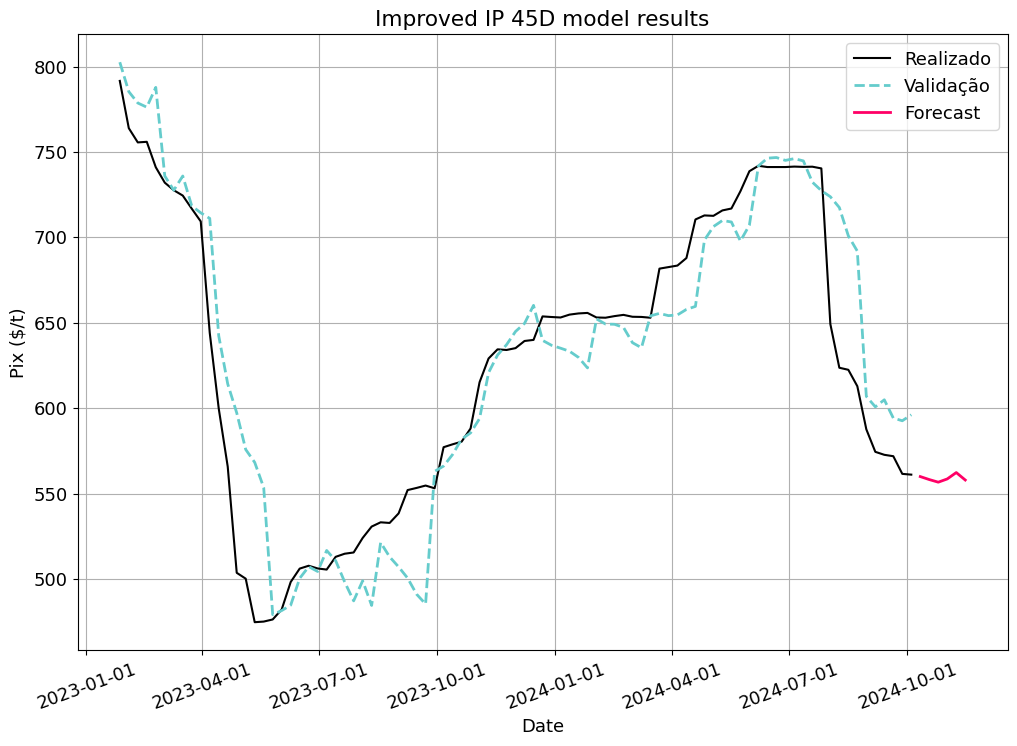

In [45]:
%matplotlib inline
model_type = models_list[2]
print(model_type)
validation_report_df = validation_report_df.sort_values("date")

import matplotlib
import matplotlib.dates as mdates
matplotlib.rcParams.update({'font.size': 13})
print(model_type)

fig, axs = plt.subplots(figsize=(12, 8), dpi=100)

axs.plot(validation_report_df[validation_report_df['MODEL_TYPE'] == model_type].date, validation_report_df[validation_report_df['MODEL_TYPE'] == model_type]['ACTUAL'], label='Realizado', color='black')
axs.plot(validation_report_df[validation_report_df['MODEL_TYPE'] == model_type].date, validation_report_df[validation_report_df['MODEL_TYPE'] == model_type][PREDICTED_COL], label=f'Validação', color=colors[2], lw=2,ls='--')
# axs.plot(validation_report_df[validation_report_df['MODEL_TYPE'] == model_type].date, validation_report_df[validation_report_df['MODEL_TYPE'] == 'XGBRegressor'][PREDICTED_COL], label=f'Validation - XGB', color=colors[3], lw=2,ls='--')

for idx, model_type in enumerate(models_list[-1:]):
    forecast_model_df = future_forecast[future_forecast['MODEL_TYPE'] == model_type]
    sns.lineplot(forecast_model_df, x='date', y='FORECAST' , label=f'Forecast', color=colors[idx+1], lw=2, markers=True, ax=axs)
    # sns.scatterplot(forecast_model_df, x='date', y='FORECAST', color=colors[idx+1], s=20, ax=axs)
    # axs.fill_between(forecast_model_df['date'], forecast_model_df['lower'], forecast_model_df['FORECAST'], color=colors[idx+1], alpha=0.2)

axs.set_title(f"Improved IP 45D model results")#.\nAvg MAPE: {(mean_metrics_by_model[mean_metrics_by_model['MODEL_TYPE'] == model_type]['MAPE']['mean'].values[0].round(4))*100}%.")
axs.set_xlabel('Date')
axs.set_ylabel('Pix ($/t)')
plt.xticks(rotation=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format x-axis ticks as dates
# axs.set_xticklabels(validation_report_df['date'].dt.date(), rotation=15, ha='right')
axs.grid(True)
plt.legend()
plt.show()

In [29]:
# future_forecast
# %matplotlib inline
# model_type = models_list[0]

# plt.figure(figsize=(12, 6))
# plt.plot(validation_report_df[validation_report_df['MODEL_TYPE'] == model_type].date, validation_report_df[validation_report_df['MODEL_TYPE'] == model_type]['ACTUAL'], label='Actual', color='blue')
# # plt.plot(validation_report_df[validation_report_df['MODEL_TYPE'] == model_type].date, validation_report_df[validation_report_df['MODEL_TYPE'] == model_type][PREDICTED_COL], label=f'Validation - {model_type}', color='black')
# plt.plot(baseline_results.date, baseline_results['FORECAST'], label=f'Validation - Baseline', color='purple')
# plt.plot(forecasts_pivoted.date, forecasts_pivoted['Ensemble'], label=f'Predicted - Ensemble', color='red')
# # plt.plot(future_forecast.date, future_forecast[PREDICTED_COL], label=f'Predicted - {model_type}', color='black')

# plt.title(f"Results of the Ensemble of boosting model. {N_SPLITS} windows of {FORECAST_HORIZON} weeks.\nAvg Overall MAPE: {avg_mape_ensemble}% | Avg 6th week's MAPE: {avg_mape_ensemble_last}%.")
# plt.xlabel('Date')
# plt.ylabel('Target')
# plt.grid(True)
# plt.legend()
# plt.show()

In [30]:
df = validation_report_df[
    validation_report_df["MODEL_TYPE"] == "CatBoostRegressor"
].copy()

In [31]:
mean_metrics_by_model

MODEL_TYPE      MAPE                         RMSE                  
                          mean  median       std       mean median        std
0  CatBoostRegressor  0.040073  0.0275  0.036533  27.354270  24.87  20.429602
1      LGBMRegressor  0.050591  0.0331  0.062642  33.860449  27.72  35.467900
2       XGBRegressor  0.052449  0.0348  0.057421  34.708202  27.97  31.214096

In [32]:
def confidence_interval_rmse(confidence_level=0.80):
    # Calculate the RMSE
    rmse = 27.2  # calculate_rmse(y_true, y_pred)

    # Determine the Z-score for the given confidence level
    z_score = stats.norm.ppf((1 + confidence_level) / 2)

    # Compute the margin of error
    margin_of_error = z_score * rmse

    # Compute the confidence interval
    lower_bound = rmse - margin_of_error
    upper_bound = rmse + margin_of_error

    return margin_of_error  # lower_bound, upper_bound

In [33]:
margin_of_error = confidence_interval_rmse()
print(f"80% confidence interval for RMSE: [{margin_of_error}]")

80% confidence interval for RMSE: [34.85820258281313]


In [34]:
mean_metrics_by_model = validation_report_df.groupby(
    ["MODEL_TYPE", "WINDOW"], as_index=False
).agg(
    {
        "MAPE": "mean",
        "RMSE": "mean",
    }
)
mean_metrics_by_model["MAPE"] = round(mean_metrics_by_model["MAPE"] * 100, 2)
mean_metrics_by_model = mean_metrics_by_model[
    mean_metrics_by_model["MODEL_TYPE"] == "CatBoostRegressor"
]

In [35]:
forecasts_pivoted = forecasts_pivoted.merge(
    mean_metrics_by_model, on=["WINDOW"], how="left"
)

In [36]:
forecasts_pivoted

,date,ACTUAL,WINDOW,CatBoostRegressor,LGBMRegressor,XGBRegressor,Ensemble,mape_by_week,MODEL_TYPE,MAPE,RMSE
0,2023-01-27,791.60,1,802.551017,792.429046,811.447571,802.142545,0.013318,CatBoostRegressor,2.75,24.87
1,2023-02-03,763.92,1,785.305032,791.680925,804.068604,793.684854,0.038963,CatBoostRegressor,2.75,24.87
2,2023-02-10,755.58,1,778.662007,791.680925,804.068604,791.470512,0.047501,CatBoostRegressor,2.75,24.87
3,2023-02-17,755.93,1,776.209093,791.680925,807.880615,791.923544,0.047615,CatBoostRegressor,2.75,24.87
4,2023-02-24,741.04,1,787.801202,791.680925,813.369873,797.617333,0.076349,CatBoostRegressor,2.75,24.87
...,...,...,...,...,...,...,...,...,...,...,...
84,2024-09-06,574.40,15,600.755296,625.494010,623.348572,616.532626,0.073351,CatBoostRegressor,4.86,28.28
85,2024-09-13,572.66,15,604.875533,629.353611,625.760376,619.996507,0.082661,CatBoostRegressor,4.86,28.28
86,2024-09-20,571.84,15,594.178976,630.578458,623.377869,616.045101,0.077303,CatBoostRegressor,4.86,28.28
87,2024-09-27,561.50,15,592.597988,635.975726,622.343811,616.972508,0.098793,CatBoostRegressor,4.86,28.28


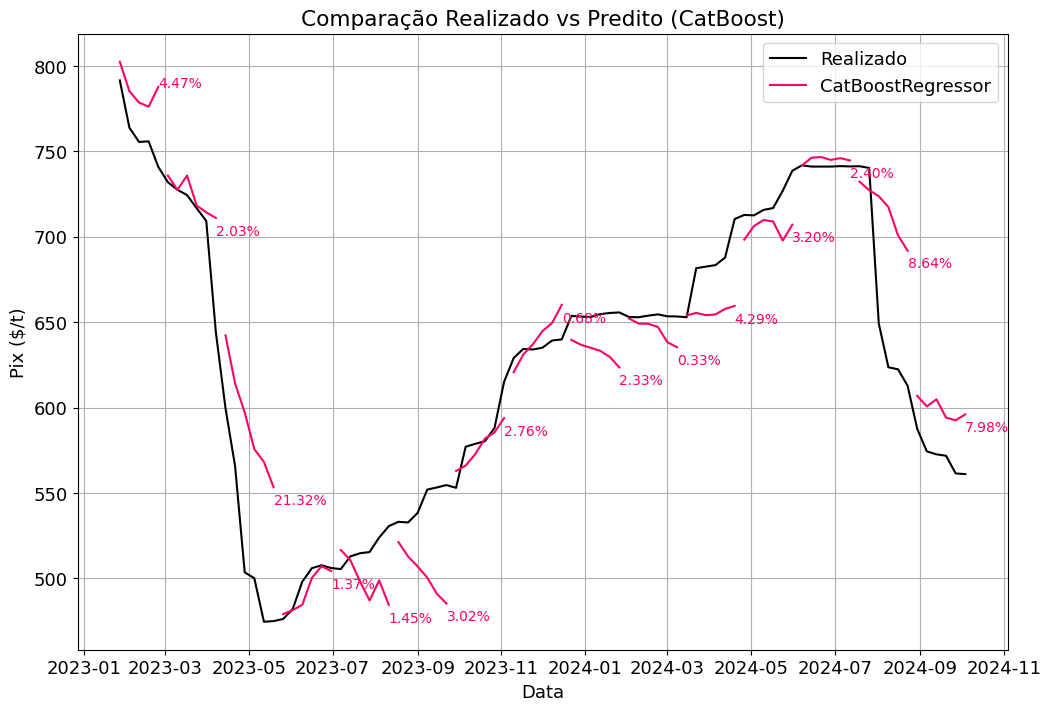

In [46]:
fig, axs = plt.subplots(figsize=(12, 8), dpi=100)
sns.lineplot(data=df, x="date", y="ACTUAL", ax=axs, color="black", label="Realizado")
# sns.lineplot(data=df, x="date", y=PREDICTED_COL, hue="WINDOW", ax=axs)
# sns.lineplot(data=validation_report_df[(validation_report_df['MODEL_TYPE'] == 'CatBoostRegressor') & (validation_report_df['WINDOW'] == 1)], x="date", y=PREDICTED_COL, color=colors[1], ax=axs, label='CatBoost')

# Calculate the position for the text
forecast_data = forecasts_pivoted[(forecasts_pivoted["WINDOW"] == 1)]
last_date = forecast_data["date"].max()
last_value = forecast_data[forecast_data["date"] == last_date][
    "CatBoostRegressor"
].values[0]
mape_value = forecast_data["MAPE"].values[
    0
]  # Assuming MAPE column exists in forecasts_pivoted

# Place the MAPE text near the last point of the line
axs.text(
    x=last_date, y=last_value, s=f"{mape_value:.2f}%", color=colors[1], fontsize=10
)
sns.lineplot(
    data=forecasts_pivoted[(forecasts_pivoted["WINDOW"] == 1)],
    x="date",
    y="CatBoostRegressor",
    color=colors[1],
    ax=axs,
    label="CatBoostRegressor",
)


for window in range(2, 16, 1):
    # sns.lineplot(data=validation_report_df[(validation_report_df['MODEL_TYPE'] == 'CatBoostRegressor') & (validation_report_df['WINDOW'] == window)], x="date", y=PREDICTED_COL, color=colors[1], ax=axs)
    forecast_data = forecasts_pivoted[(forecasts_pivoted["WINDOW"] == window)]
    sns.lineplot(
        data=forecast_data, x="date", y="CatBoostRegressor", color=colors[1], ax=axs
    )

    # Calculate the position for the text
    last_date = forecast_data["date"].max()
    last_value = forecast_data[forecast_data["date"] == last_date][
        "CatBoostRegressor"
    ].values[0]
    mape_value = forecast_data["MAPE"].values[
        0
    ]  # Assuming MAPE column exists in forecasts_pivoted

    # Place the MAPE text near the last point of the line
    axs.text(
        x=last_date,
        y=last_value - 10,
        s=f"{mape_value:.2f}%",
        color=colors[1],
        fontsize=10,
    )


axs.set_title("Comparação Realizado vs Predito (CatBoost)")
axs.set_ylabel("Pix ($/t)")
axs.set_xlabel("Data")

plt.grid()
plt.show()

In [38]:
mape_ensemble["MAPE"] = round(mape_ensemble["MAPE"] * 100, 2)

In [39]:
forecasts_pivoted = forecasts_pivoted.drop(columns=["MODEL_TYPE", "MAPE", "RMSE"])
forecasts_pivoted = forecasts_pivoted.merge(mape_ensemble, on=["WINDOW"], how="left")

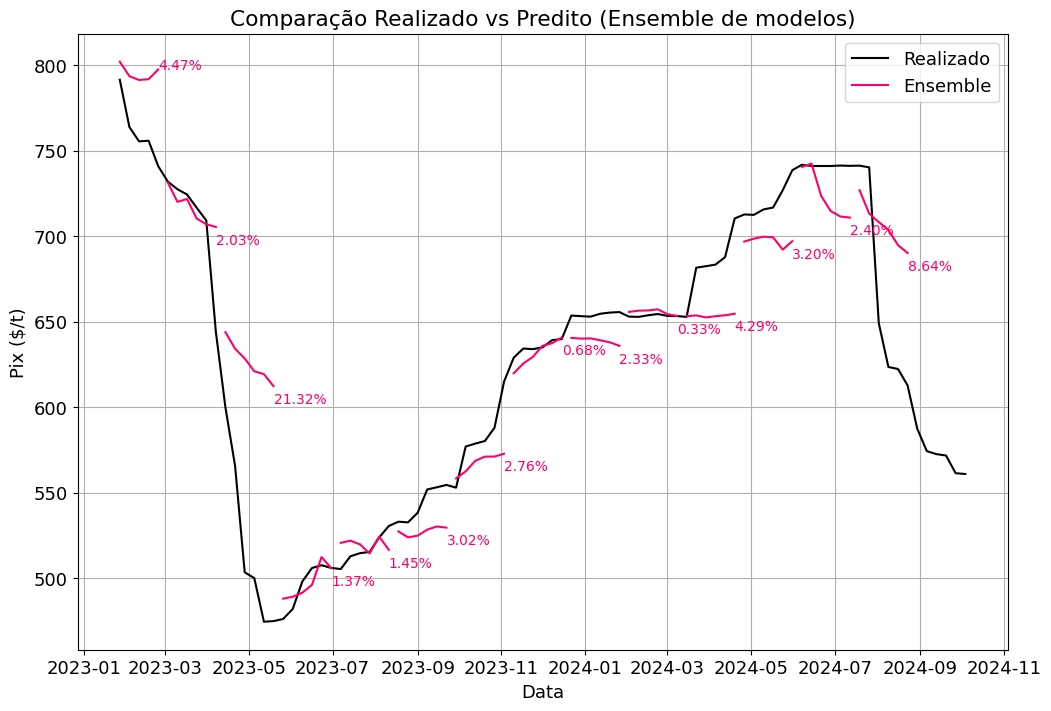

In [40]:
fig, axs = plt.subplots(figsize=(12, 8), dpi=100)
sns.lineplot(data=df, x="date", y="ACTUAL", ax=axs, color="black", label="Realizado")
# sns.lineplot(data=df, x="date", y=PREDICTED_COL, hue="WINDOW", ax=axs)
# sns.lineplot(data=validation_report_df[(validation_report_df['MODEL_TYPE'] == 'CatBoostRegressor') & (validation_report_df['WINDOW'] == 1)], x="date", y=PREDICTED_COL, color=colors[1], ax=axs, label='CatBoost')

# Calculate the position for the text
forecast_data = forecasts_pivoted[(forecasts_pivoted["WINDOW"] == 1)]
last_date = forecast_data["date"].max()
last_value = forecast_data[forecast_data["date"] == last_date]["Ensemble"].values[0]
mape_value = forecast_data["MAPE"].values[
    0
]  # Assuming MAPE column exists in forecasts_pivoted

# Place the MAPE text near the last point of the line
axs.text(
    x=last_date, y=last_value, s=f"{mape_value:.2f}%", color=colors[1], fontsize=10
)
sns.lineplot(
    data=forecasts_pivoted[(forecasts_pivoted["WINDOW"] == 1)],
    x="date",
    y="Ensemble",
    color=colors[1],
    ax=axs,
    label="Ensemble",
)


for window in range(2, 15, 1):
    forecast_data = forecasts_pivoted[(forecasts_pivoted["WINDOW"] == window)]
    sns.lineplot(data=forecast_data, x="date", y="Ensemble", color=colors[1], ax=axs)

    # Calculate the position for the text
    last_date = forecast_data["date"].max()
    last_value = forecast_data[forecast_data["date"] == last_date]["Ensemble"].values[0]
    mape_value = forecast_data["MAPE"].values[
        0
    ]  # Assuming MAPE column exists in forecasts_pivoted

    # Place the MAPE text near the last point of the line
    axs.text(
        x=last_date,
        y=last_value - 10,
        s=f"{mape_value:.2f}%",
        color=colors[1],
        fontsize=10,
    )


axs.set_title("Comparação Realizado vs Predito (Ensemble de modelos)")
axs.set_ylabel("Pix ($/t)")
axs.set_xlabel("Data")
plt.grid()
plt.show()

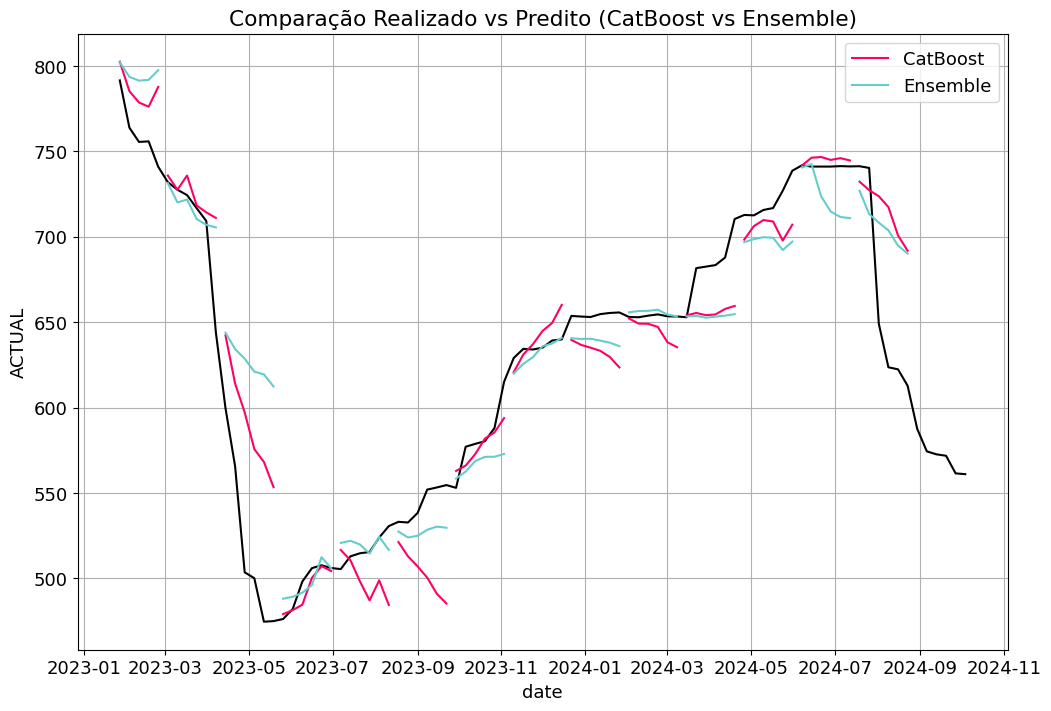

In [41]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.lineplot(data=df, x="date", y="ACTUAL", ax=axs, color="black")
# sns.lineplot(data=df, x="date", y=PREDICTED_COL, hue="WINDOW", ax=axs)
sns.lineplot(
    data=validation_report_df[
        (validation_report_df["MODEL_TYPE"] == "CatBoostRegressor")
        & (validation_report_df["WINDOW"] == 1)
    ],
    x="date",
    y=PREDICTED_COL,
    color=colors[1],
    ax=axs,
    label="CatBoost",
)
sns.lineplot(
    data=forecasts_pivoted[(forecasts_pivoted["WINDOW"] == 1)],
    x="date",
    y="Ensemble",
    color=colors[2],
    ax=axs,
    label="Ensemble",
)

for window in range(2, 15, 1):
    sns.lineplot(
        data=validation_report_df[
            (validation_report_df["MODEL_TYPE"] == "CatBoostRegressor")
            & (validation_report_df["WINDOW"] == window)
        ],
        x="date",
        y=PREDICTED_COL,
        color=colors[1],
        ax=axs,
    )
    sns.lineplot(
        data=forecasts_pivoted[(forecasts_pivoted["WINDOW"] == window)],
        x="date",
        y="Ensemble",
        color=colors[2],
        ax=axs,
    )

axs.set_title("Comparação Realizado vs Predito (CatBoost vs Ensemble)")
plt.grid()
plt.show()

In [42]:
baseline_results_plot = baseline_results.copy()
baseline_results_plot["MAPE"] = round(baseline_results_plot["MAPE"] * 100, 2)

In [43]:
baseline_results_plot[baseline_results_plot["WINDOW"] == 3]

,date,presentation,presentation month,pix reference date,pix reference,ACTUAL,FORECAST,drift (usd/t),error,model run date,forecast mape,week,WINDOW,mape_by_week,MAPE
11,2023-04-14,Insights Platform Call,2023-03-01,2023-03-24,716.780029,599.750000,703.984833,-104.234833,0.173797,NaT,0.0133,3,3,0.173797,32.37
12,2023-04-21,Insights Platform Call,2023-03-01,2023-03-24,716.780029,565.710022,730.608146,-164.898124,0.291489,NaT,0.0133,4,3,0.291489,32.37
13,2023-04-28,Insights Platform Call,2023-03-01,2023-03-24,716.780029,503.570000,707.097202,-203.527202,0.404169,NaT,0.0133,5,3,0.404169,32.37
14,2023-05-05,Insights Platform Call,2023-03-01,2023-03-24,716.780029,500.130000,712.848218,-212.718218,0.425326,NaT,0.0133,6,3,0.425326,32.37


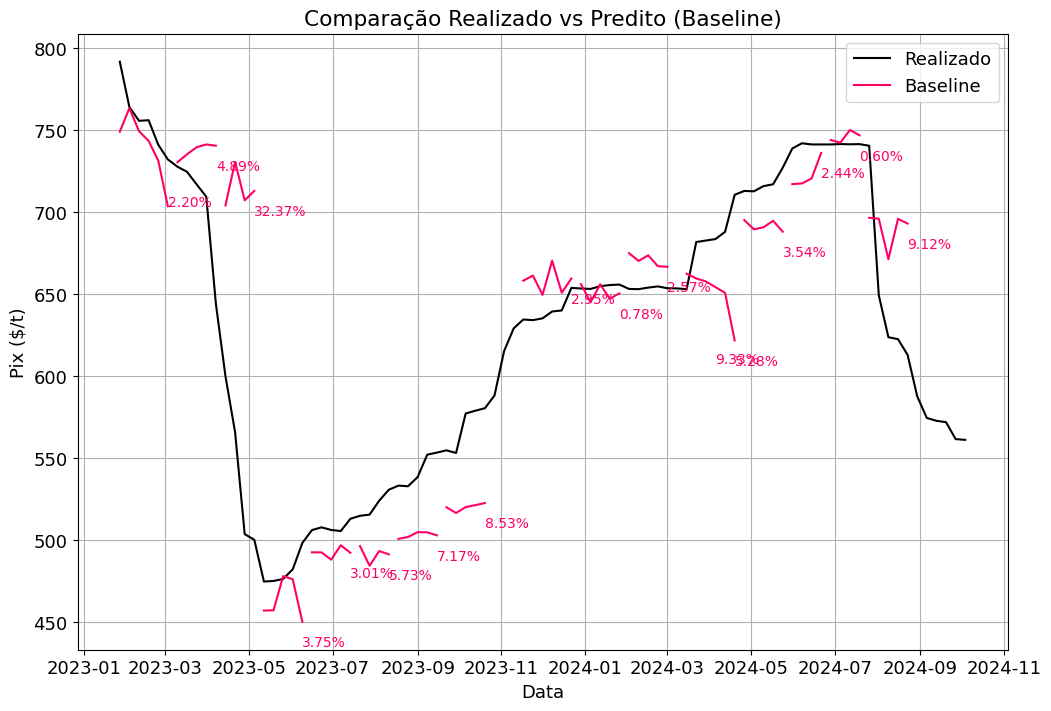

In [44]:
fig, axs = plt.subplots(figsize=(12, 8), dpi=100)
sns.lineplot(data=df, x="date", y="ACTUAL", ax=axs, color="black", label="Realizado")
# sns.lineplot(data=df, x="date", y=PREDICTED_COL, hue="WINDOW", ax=axs)
# sns.lineplot(data=validation_report_df[(validation_report_df['MODEL_TYPE'] == 'CatBoostRegressor') & (validation_report_df['WINDOW'] == 1)], x="date", y=PREDICTED_COL, color=colors[1], ax=axs, label='CatBoost')

# Calculate the position for the text
forecast_data = baseline_results_plot[(baseline_results_plot["WINDOW"] == 1)]
last_date = forecast_data["date"].max()
last_value = forecast_data[forecast_data["date"] == last_date]["FORECAST"].values[0]
mape_value = forecast_data["MAPE"].values[
    0
]  # Assuming MAPE column exists in baseline_results_plot

# Place the MAPE text near the last point of the line
axs.text(
    x=last_date, y=last_value, s=f"{mape_value:.2f}%", color=colors[1], fontsize=10
)
sns.lineplot(
    data=baseline_results_plot[(baseline_results_plot["WINDOW"] == 1)],
    x="date",
    y="FORECAST",
    color=colors[1],
    ax=axs,
    label="Baseline",
)


for window in range(2, 18, 1):
    # sns.lineplot(data=validation_report_df[(validation_report_df['MODEL_TYPE'] == 'CatBoostRegressor') & (validation_report_df['WINDOW'] == window)], x="date", y=PREDICTED_COL, color=colors[1], ax=axs)
    forecast_data = baseline_results_plot[(baseline_results_plot["WINDOW"] == window)]
    sns.lineplot(data=forecast_data, x="date", y="FORECAST", color=colors[1], ax=axs)

    # Calculate the position for the text
    last_date = forecast_data["date"].max()
    last_value = forecast_data[forecast_data["date"] == last_date]["FORECAST"].values[0]
    mape_value = forecast_data["MAPE"].values[
        0
    ]  # Assuming MAPE column exists in forecasts_pivoted

    # Place the MAPE text near the last point of the line
    axs.text(
        x=last_date,
        y=last_value - 15,
        s=f"{mape_value:.2f}%",
        color=colors[1],
        fontsize=10,
    )


axs.set_title("Comparação Realizado vs Predito (Baseline)")
axs.set_ylabel("Pix ($/t)")
axs.set_xlabel("Data")
plt.grid()
plt.show()

### 4.3 Calculando os erros apenas da 6° Semana: A mais importante

---

## 5.0 Estudando o Resíduo dos modelos e Overfitting

### 5.1 Avaliando Overfitting através dos MAPES de treinamento vs teste.

Os erros no teste estão muito maior do que no treino!! Talvez os modelos estejam overfittando.

In [101]:
validation_report_df["rmse_gap"] = (
    validation_report_df["RMSE"] / validation_report_df["TRAINING_RMSE"]
).round(2)
validation_report_df["mape_gap"] = (
    validation_report_df["MAPE"] / validation_report_df["TRAINING_MAPE"]
).round(2)

In [102]:
model_val = validation_report_df[
    validation_report_df["MODEL_TYPE"].isin(["LGBMRegressor", "CatBoostRegressor"])
].copy()

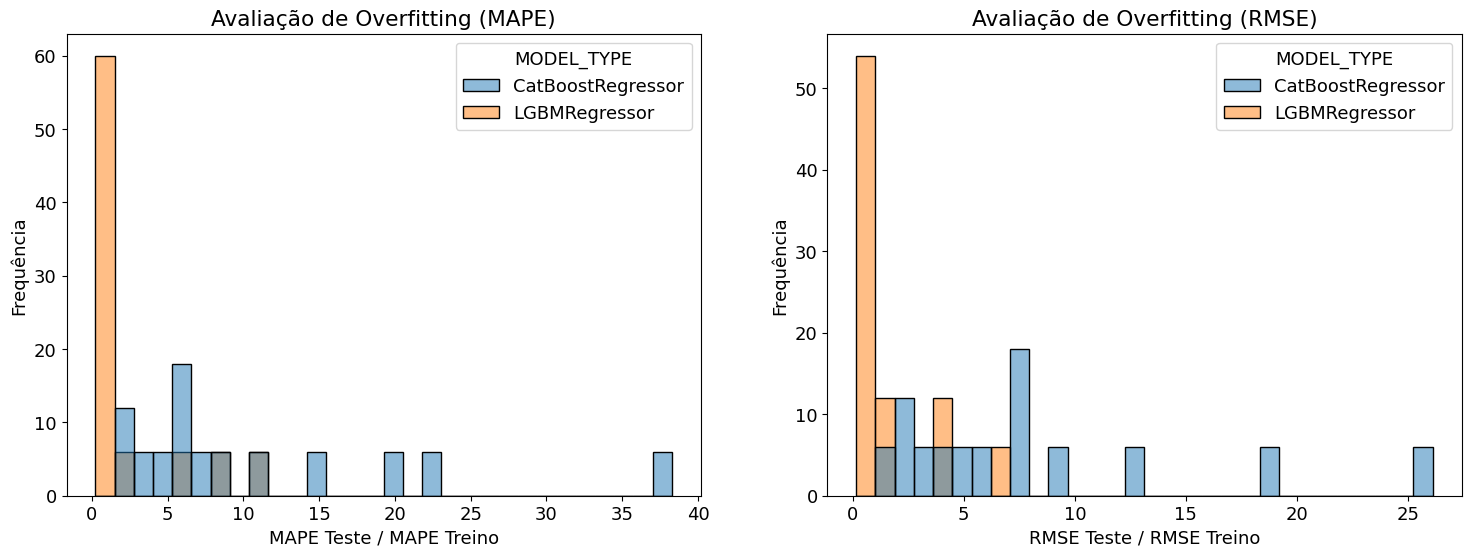

In [103]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data=model_val, x="mape_gap", bins=30, ax=axs[0], hue="MODEL_TYPE")
axs[0].set_title("Avaliação de Overfitting (MAPE)")
axs[0].set_xlabel("MAPE Teste / MAPE Treino")
axs[0].set_ylabel("Frequência")

sns.histplot(data=model_val, x="rmse_gap", bins=30, ax=axs[1], hue="MODEL_TYPE")
axs[1].set_title("Avaliação de Overfitting (RMSE)")
axs[1].set_xlabel("RMSE Teste / RMSE Treino")
axs[1].set_ylabel("Frequência")
plt.show()

### 5.2 Avaliação de Resíduos

In [104]:
model_val["resid"] = model_val["ACTUAL"] - model_val["FORECAST"]

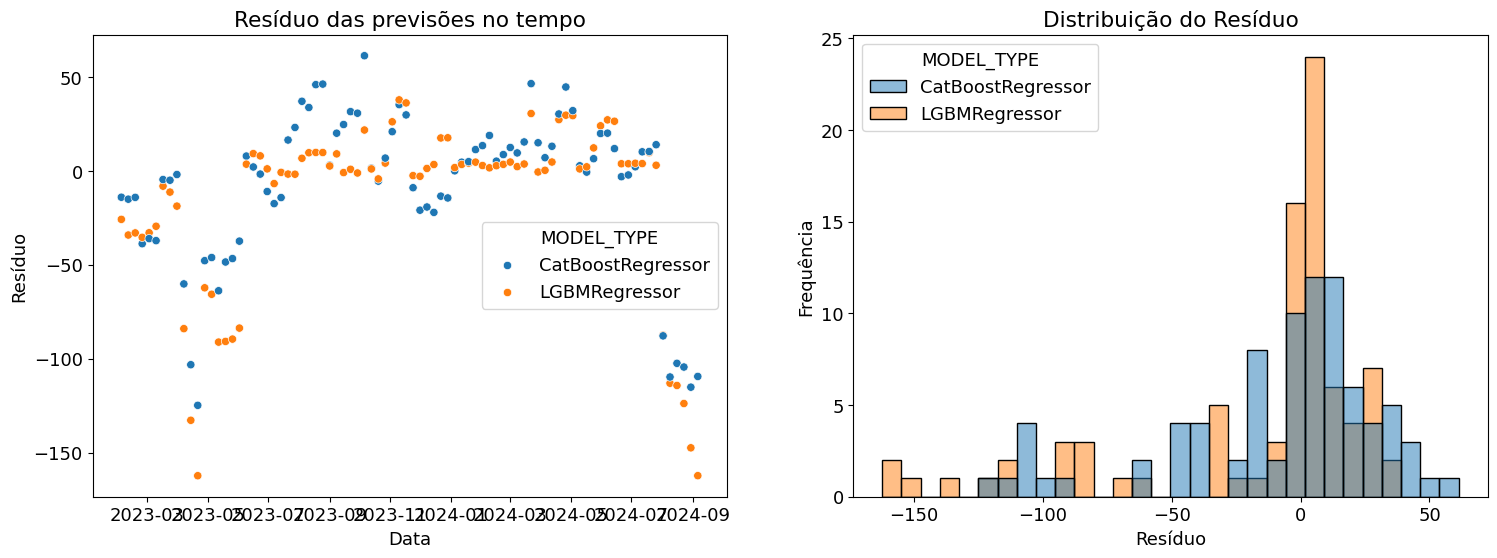

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(data=model_val, x="date", y="resid", ax=axs[0], hue="MODEL_TYPE")
axs[0].set_title("Resíduo das previsões no tempo")
axs[0].set_xlabel("Data")
axs[0].set_ylabel("Resíduo")

sns.histplot(data=model_val, x="resid", bins=30, ax=axs[1], hue="MODEL_TYPE")
axs[1].set_title("Distribuição do Resíduo")
axs[1].set_xlabel("Resíduo")
axs[1].set_ylabel("Frequência")

plt.show()

In [106]:
for model_type in model_val["MODEL_TYPE"].unique():
    print(f"Testing the Resid normality of model {model_type}")
    uf.test_for_normality(model_val[model_val["MODEL_TYPE"] == model_type], "resid")
    print("\n")

Testing the Resid normality of model CatBoostRegressor
-------------------- Testing for Normality using Shapiro-Wilk test --------------------
Statistic: 0.8797579438073516
P-value: 1.1484902725089145e-06

!!!!! The |resid| series DOES NOT follow Normal Distribution !!!!!!


Testing the Resid normality of model LGBMRegressor
-------------------- Testing for Normality using Shapiro-Wilk test --------------------
Statistic: 0.7538176609665703
P-value: 1.4908547360941422e-10

!!!!! The |resid| series DOES NOT follow Normal Distribution !!!!!!




Removendo o período outlier

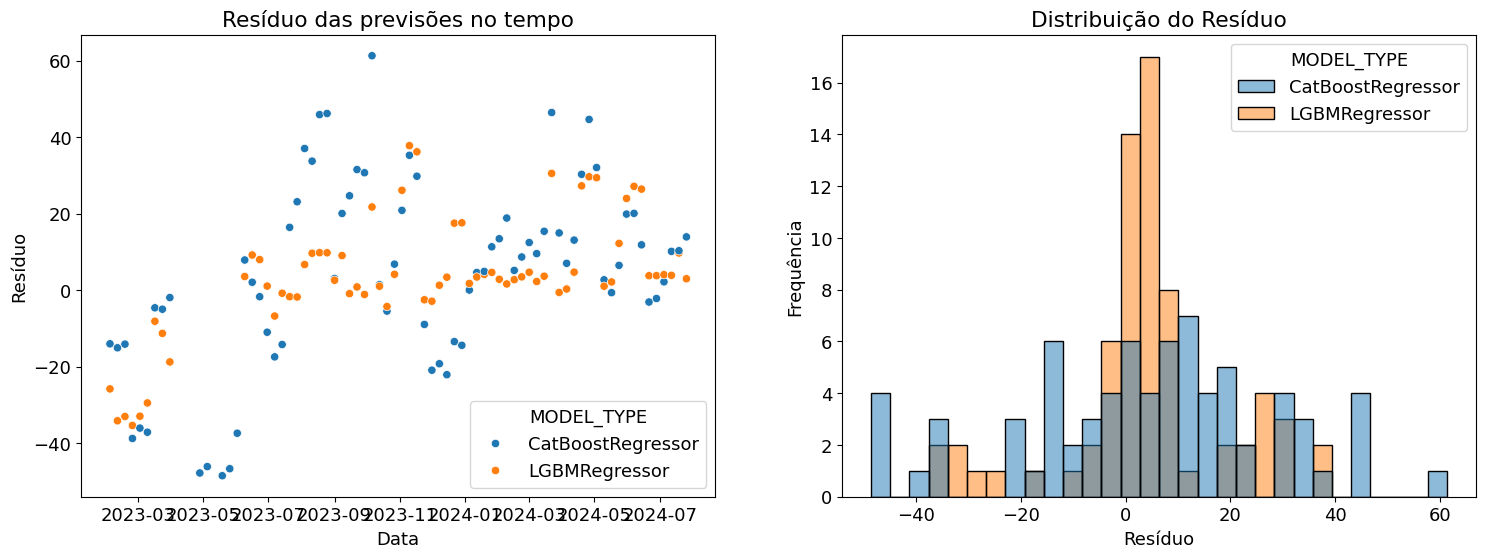

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(
    data=model_val[(model_val["resid"] >= -50)],
    x="date",
    y="resid",
    ax=axs[0],
    hue="MODEL_TYPE",
)
axs[0].set_title("Resíduo das previsões no tempo")
axs[0].set_xlabel("Data")
axs[0].set_ylabel("Resíduo")

sns.histplot(
    data=model_val[(model_val["resid"] >= -50)],
    x="resid",
    bins=30,
    ax=axs[1],
    hue="MODEL_TYPE",
)
axs[1].set_title("Distribuição do Resíduo")
axs[1].set_xlabel("Resíduo")
axs[1].set_ylabel("Frequência")

plt.show()

In [108]:
for model_type in model_val["MODEL_TYPE"].unique():
    print(f"Testing the Resid normality of model {model_type}")
    uf.test_for_normality(
        model_val[
            (model_val["MODEL_TYPE"] == model_type) & (model_val["resid"] >= -50)
        ],
        "resid",
    )
    print("\n")

Testing the Resid normality of model CatBoostRegressor
-------------------- Testing for Normality using Shapiro-Wilk test --------------------
Statistic: 0.9784926252201033
P-value: 0.23866941460512664

The |resid| series data FOLLOWS a Normal Distribution!


Testing the Resid normality of model LGBMRegressor
-------------------- Testing for Normality using Shapiro-Wilk test --------------------
Statistic: 0.9057310907954319
P-value: 7.379391961776897e-05

!!!!! The |resid| series DOES NOT follow Normal Distribution !!!!!!




## 7.0 Shap Values

### 7.1 Shap Values da Janela 5 (Erro feio)

In [228]:
import mlflow

WINDOW = 14
MODEL = "CatBoostRegressor"
# shapTrainPath = "./data/output/mlflow/shap_values_train.csv"
# shapTestPath = "./data/output/mlflow/shap_values_test.csv"
X_trains_path = "./data/output/mlflow/less_pix/X_trains_9.csv"
X_tests_path = "./data/output/mlflow/less_pix/X_test_efective_9.csv"

# shapTrainDf = pd.read_csv(shapTrainPath)
# shapTestDf = pd.read_csv(shapTestPath)
X_trains = pd.read_csv(X_trains_path)
X_tests = pd.read_csv(X_tests_path)

logged_model = (
    f"runs:/b967ae1327fe40bba20bd9e8dfe96a5f/{MODEL}_it_{WINDOW}"  # CatBoostRegressor
)
# logged_model = f"runs:/c24b5b83ce444a688ccb7478a0389f88/{MODEL}_it_{WINDOW}" # LightGBM
# logged_model = f"runs:/9c08f7a257744591a203c303958bf6af/{MODEL}_it_{WINDOW}" # XGBRegressor
loaded_model = mlflow.sklearn.load_model(logged_model)

X_test = X_tests[
    (X_tests["WINDOW"] == WINDOW) & (X_tests["MODEL_TYPE"] == MODEL)
].copy()
X_train = X_trains[X_trains["WINDOW"] == WINDOW].copy()

X_train_clean = X_train.drop(columns=["WINDOW", "date"]).copy()
X_test_clean = X_test.drop(columns=["WINDOW", "date", "MODEL_TYPE", "FORECAST"]).copy()

# shapTrain = (
#     shapTrainDf[
#         (shapTrainDf["WINDOW"] == WINDOW) & (shapTrainDf["MODEL_TYPE"] == MODEL)
#     ]
#     .copy()
#     .drop(columns=["WINDOW", "MODEL_TYPE"])
# )
# shapTest = (
#     shapTestDf[(shapTestDf["WINDOW"] == WINDOW) & (shapTrainDf["MODEL_TYPE"] == MODEL)]
#     .copy()
#     .drop(columns=["WINDOW", "MODEL_TYPE"])
# )

In [229]:
# Initialize the SHAP explainer
explainer = shap.Explainer(loaded_model)
# Compute SHAP values for the Training data
shap_values_train = explainer(X_train_clean)
shap_values_test = explainer(X_test_clean)

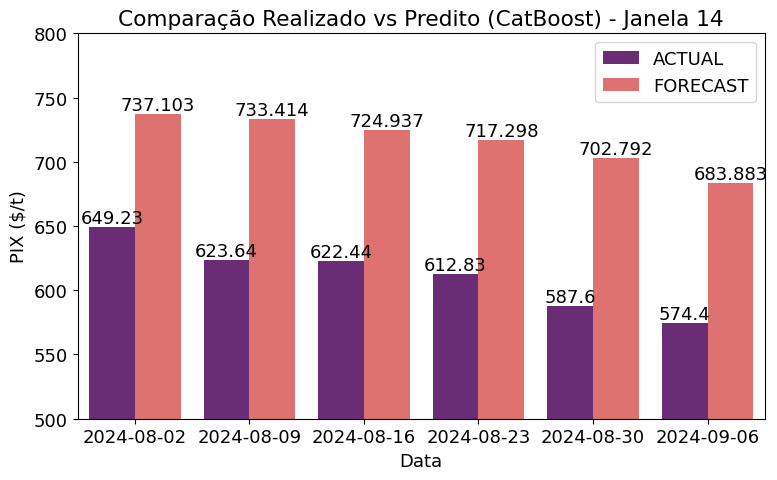

In [230]:
previsao_melted = pd.melt(
    df,
    id_vars=["date", "MODEL_TYPE", "WINDOW"],
    value_vars=["ACTUAL", "FORECAST"],
    var_name="tipo_do_valor",
    value_name="valor",
)
previsao_melted.head()

fig, axs = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=previsao_melted[previsao_melted["WINDOW"] == WINDOW],
    x="date",
    y="valor",
    ax=axs,
    hue="tipo_do_valor",
    palette="magma",
)

for container in axs.containers:
    axs.bar_label(container)

axs.set_title(f"Comparação Realizado vs Predito (CatBoost) - Janela {WINDOW}")
axs.set_ylabel("PIX ($/t)")
axs.set_xlabel("Data")
axs.set_ylim(500, 800)
plt.tight_layout()
plt.legend()
plt.show()

#### 7.1.1 Summary plot for the training data

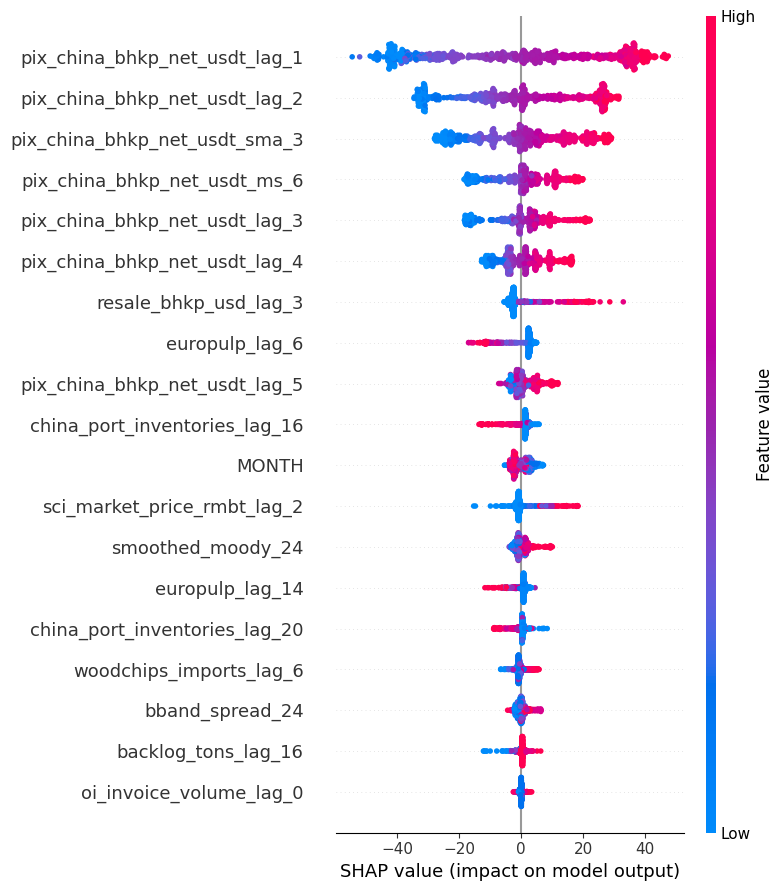

In [231]:
# Summary plot
shap.summary_plot(shap_values_train, X_train_clean)

# Cat

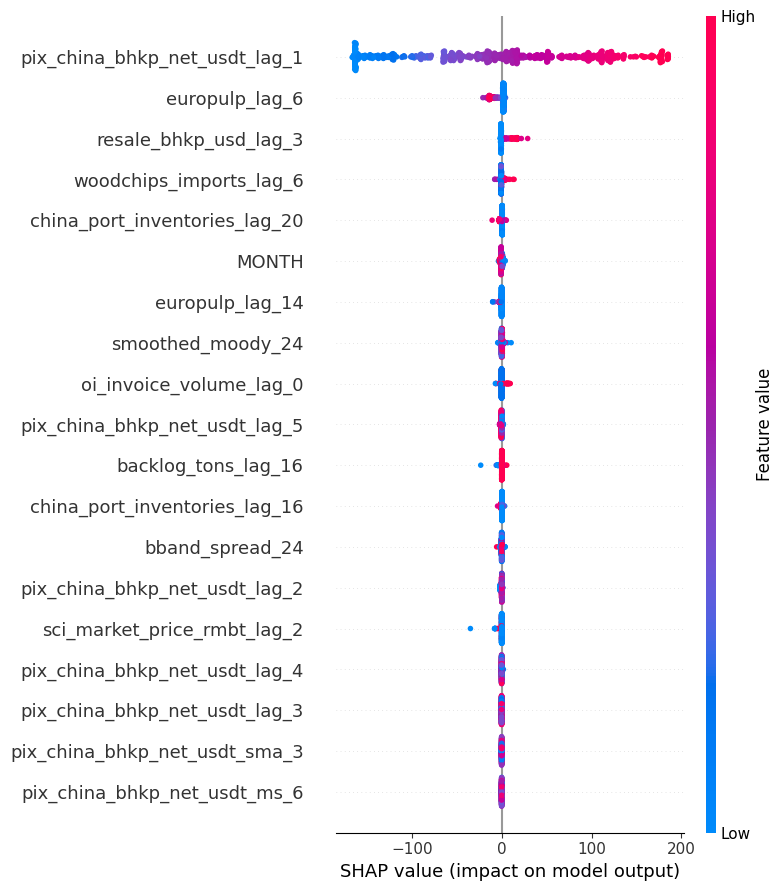

In [227]:
# Summary plot
shap.summary_plot(shap_values_train, X_train_clean)
#  XGB

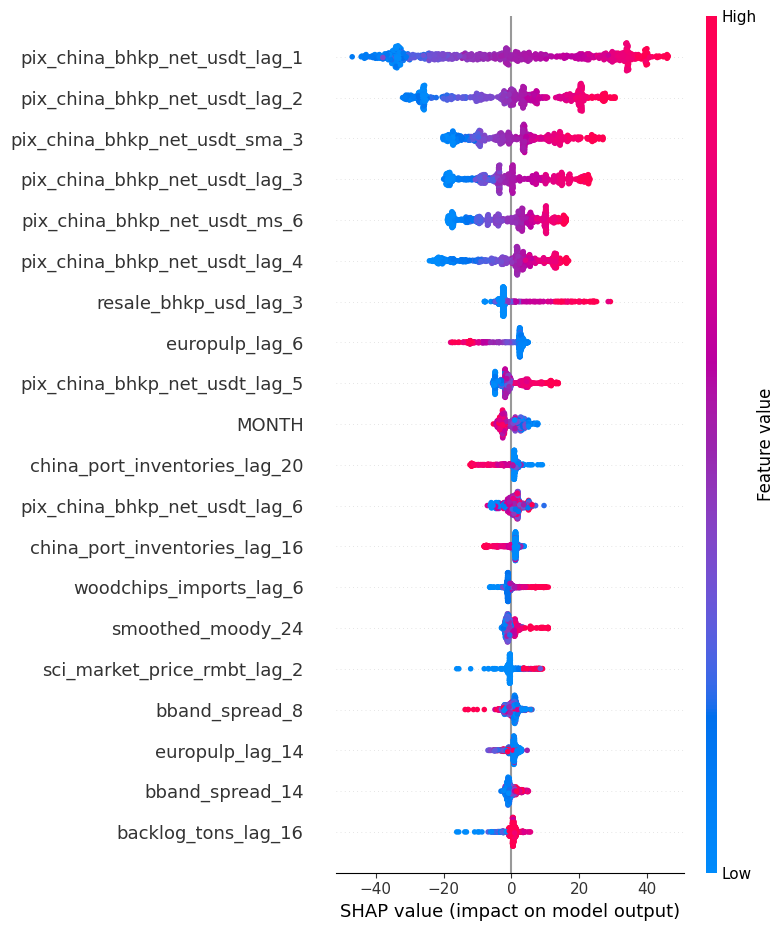

In [223]:
# Summary plot
shap.summary_plot(shap_values_train, X_train_clean)

#### 7.1.2 Waterfall plot

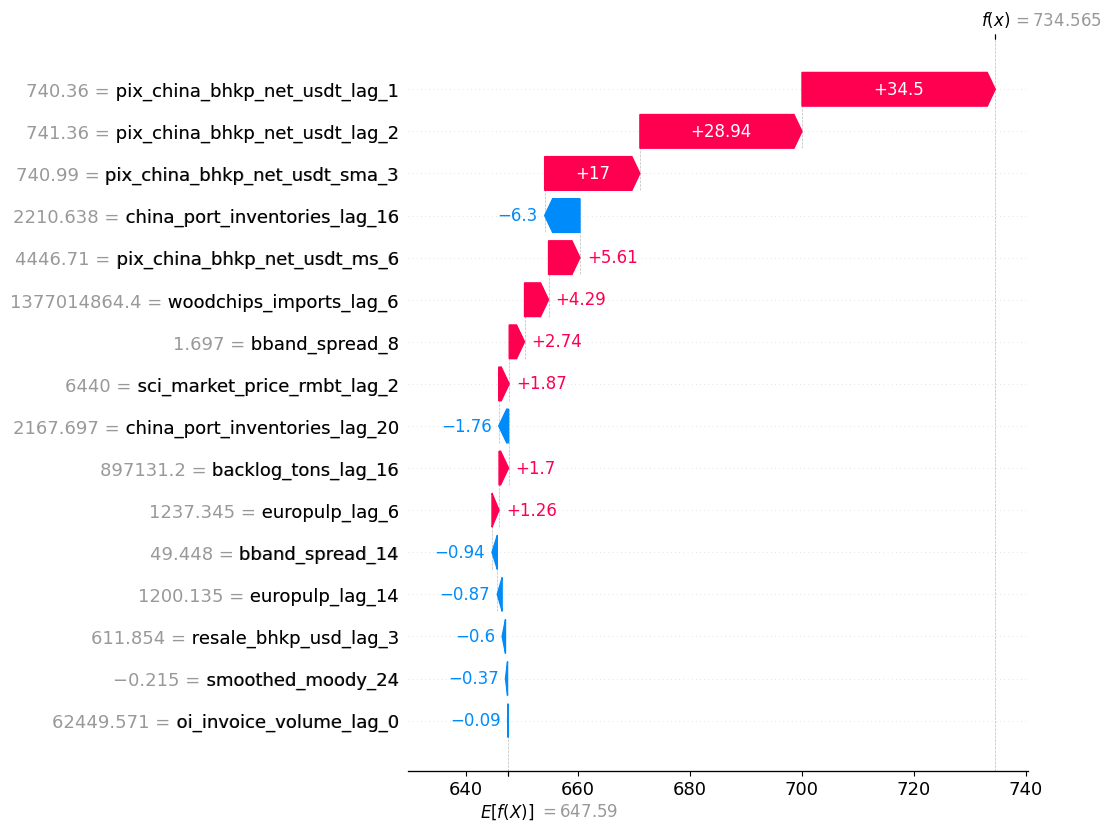

In [205]:
# Plot SHAP Waterfall plot for the first observation
instance_index = 0
shap.plots.waterfall(shap_values_test[instance_index], max_display=100)

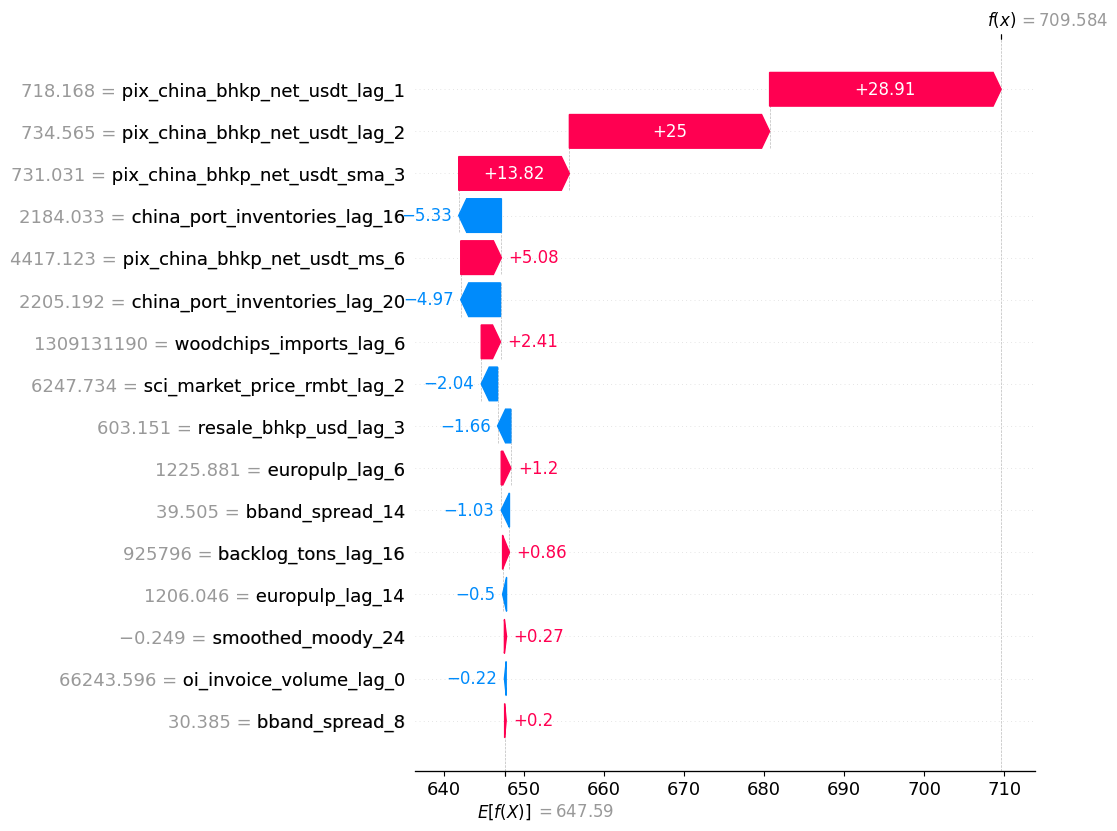

In [206]:
# Plot SHAP Waterfall plot for the first observation
instance_index = 2
shap.plots.waterfall(shap_values_test[instance_index], max_display=100)

#### 7.1.3 Scatter plot and Partial Dependency

In [187]:
translate_columns = {}
for idx, col in enumerate(X_train_clean.columns):
    translate_columns[col] = idx
print(X_train_clean.columns)

Index(['pix_china_bhkp_net_usdt_lag_1', 'pix_china_bhkp_net_usdt_ms_6',
       'pix_china_bhkp_net_usdt_ms_24', 'bband_spread_20',
       'oi_invoice_volume_lag_0', 'woodchips_imports_lag_6',
       'china_port_inventories_lag_16', 'china_port_inventories_lag_20',
       'europulp_lag_6', 'europulp_lag_14', 'resale_bhkp_usd_lag_3',
       'sci_market_price_rmbt_lag_2', 'backlog_tons_lag_16',
       'smoothed_moody_24'],
      dtype='object')


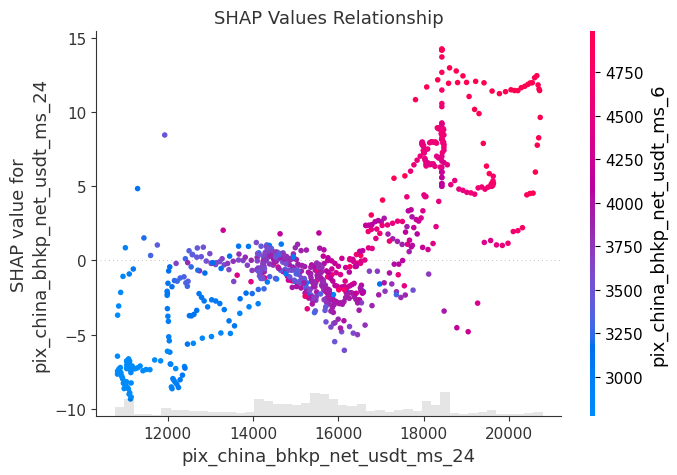

In [192]:
main_feature = "pix_china_bhkp_net_usdt_ms_24"
color_feature = "pix_china_bhkp_net_usdt_ms_6"
shap.plots.scatter(
    shap_values_train[:, translate_columns[main_feature]],
    color=shap_values_train[:, translate_columns[color_feature]],
    title="SHAP Values Relationship",
)

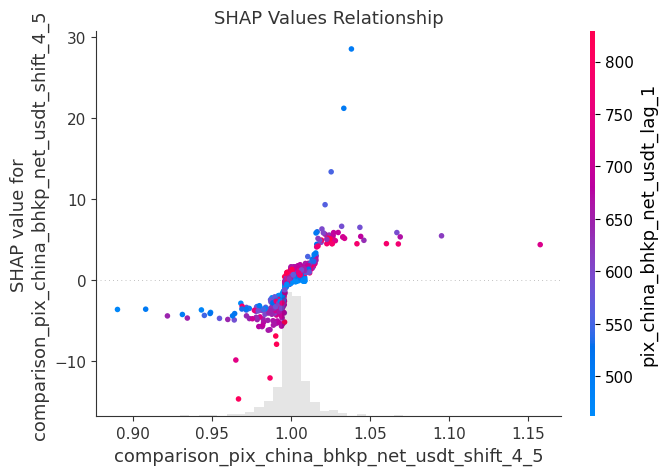

In [126]:
shap.plots.scatter(
    shap_values_train[:, 4],
    color=shap_values_train[:, 0],
    title="SHAP Values Relationship",
)

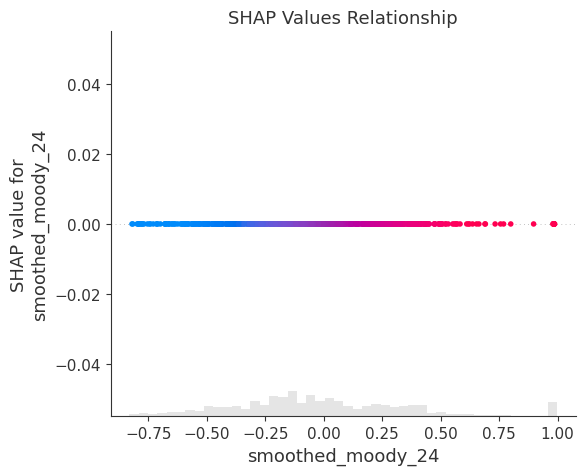

In [64]:
shap.plots.scatter(
    shap_values_train[:, -1],
    color=shap_values_train[:, -2],
    title="SHAP Values Relationship",
)

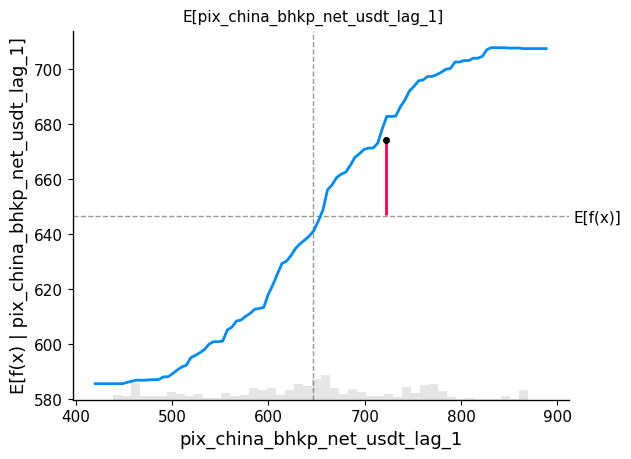

In [65]:
shap.partial_dependence_plot(
    0,
    loaded_model.predict,
    X_train_clean,
    feature_names=X_train_clean.columns,
    ice=False,
    show=True,
    model_expected_value=True,
    feature_expected_value=True,
    shap_values=shap_values_test[instance_index : instance_index + 1, :],
)

In [66]:
clustering = shap.utils.hclust(
    X_train_clean, X_train_clean["pix_china_bhkp_net_usdt_lag_1"].shift(-1).ffill()
)

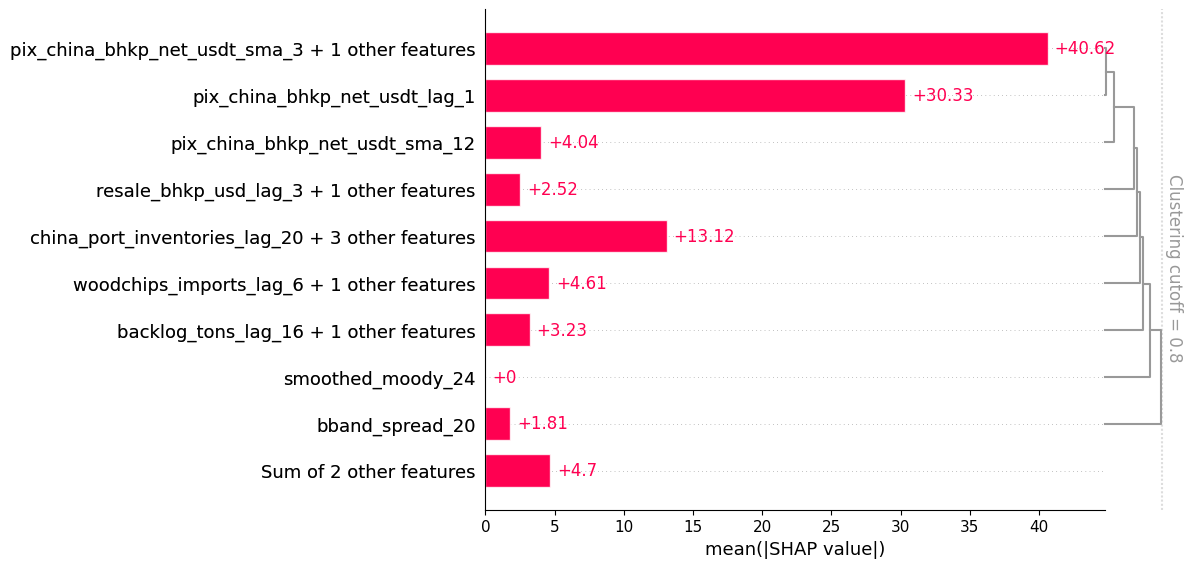

In [67]:
shap.plots.bar(shap_values_train, clustering=clustering, clustering_cutoff=0.8)

### 7.2 Ajustando o Shap para utilizar o último valor como referência em vez do valor médio

In [68]:
# Initialize the SHAP explainer
explainer = shap.Explainer(loaded_model)
# Compute SHAP values for the Training data
shap_test = explainer.shap_values(X_test_clean)

In [69]:
instance_index = 0
last_price = X_test["pix_china_bhkp_net_usdt_lag_1"].values[
    instance_index
]  # Last observed price
predicted_price = X_test["FORECAST"].values[
    instance_index
]  # Predicted price for the next period

In [70]:
# Get the SHAP values for a specific instance (e.g., the first instance)
instance_shap_values = shap_test[instance_index]

# Calculate the sum of SHAP values (the contributions)
sum_shap_values = sum(instance_shap_values)

# Adjust the SHAP values to sum to the difference between the predicted and last price
adjusted_shap_values = instance_shap_values * (
    (predicted_price - last_price) / sum_shap_values
)

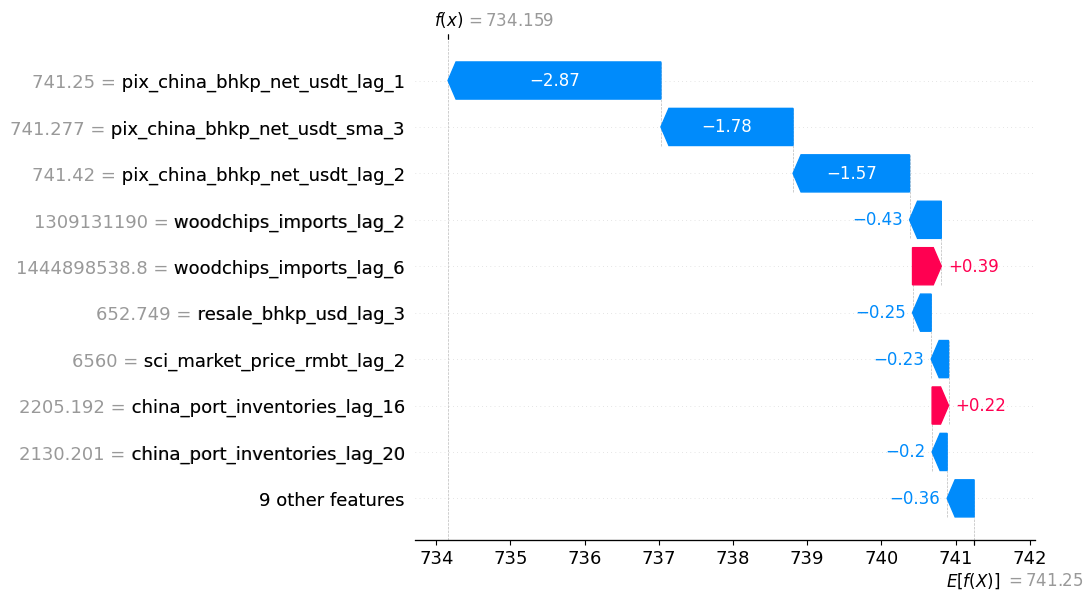

In [71]:
# Create a SHAP Explanation object with the adjusted SHAP values
adjusted_shap_explanation = shap.Explanation(
    values=adjusted_shap_values,
    base_values=last_price,
    data=X_test_clean.iloc[instance_index],
    feature_names=X_test_clean.columns,
)

# Plot the waterfall plot
shap.plots.waterfall(adjusted_shap_explanation)

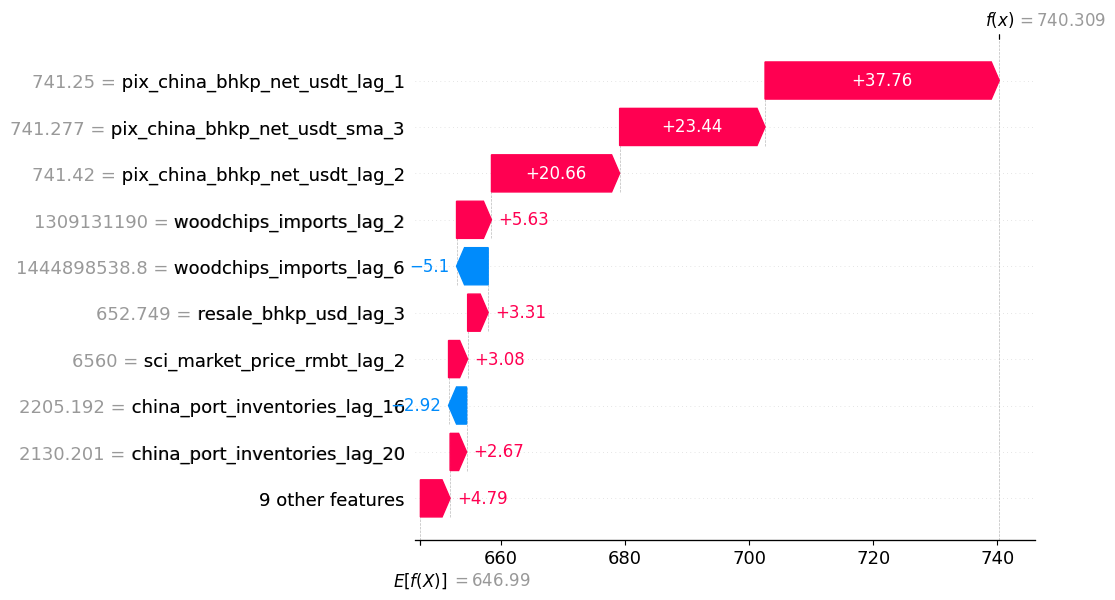

In [72]:
shap.plots.waterfall(shap_values_test[instance_index])

## 8.0 Analisando as previsões feitas para Agosto

**Objective**: Entender porque o modelo não está conseguindo prever bem o Downcycle de Agosto

In [73]:
import mlflow

WINDOW = 14
MODEL = "CatBoostRegressor"

processed_df_path = "./data/output/mlflow/last_stable_model_agosto/processed_df.csv"
val_df_path = "./data/output/mlflow/last_stable_model_agosto/validation_report_df.csv"
X_trains_path = "./data/output/mlflow/last_stable_model_agosto/X_trains.csv"
X_tests_path = "./data/output/mlflow/last_stable_model_agosto/X_test_efective.csv"

processed_df = pd.read_csv(processed_df_path, parse_dates=["date"])
val_df = pd.read_csv(val_df_path, parse_dates=["date"])
X_trains = pd.read_csv(X_trains_path, parse_dates=["date"])
X_tests = pd.read_csv(X_tests_path, parse_dates=["date"])

logged_model = f"runs:/09965a224ac04c75bbea306fc68c29bb/{MODEL}_it_{WINDOW}"
loaded_model = mlflow.sklearn.load_model(logged_model)

val_df_window = val_df[val_df["WINDOW"] == WINDOW].copy()
past_df = val_df[val_df["WINDOW"] == WINDOW - 1].copy()
X_train = X_trains[X_trains["WINDOW"] == WINDOW].copy()
X_test = X_tests[X_tests["WINDOW"] == WINDOW].copy()
X_test_past = X_tests[X_tests["WINDOW"] == WINDOW - 1].copy()

X_test_analysis = X_test[X_test["MODEL_TYPE"] == MODEL].copy()
X_test_analysis_past = X_test_past[X_test_past["MODEL_TYPE"] == MODEL].copy()

In [74]:
X_test_analysis = X_test_analysis.set_index("date").join(
    processed_df.set_index("date")[["pix_china_bhkp_net_usdt"]], how="left"
)

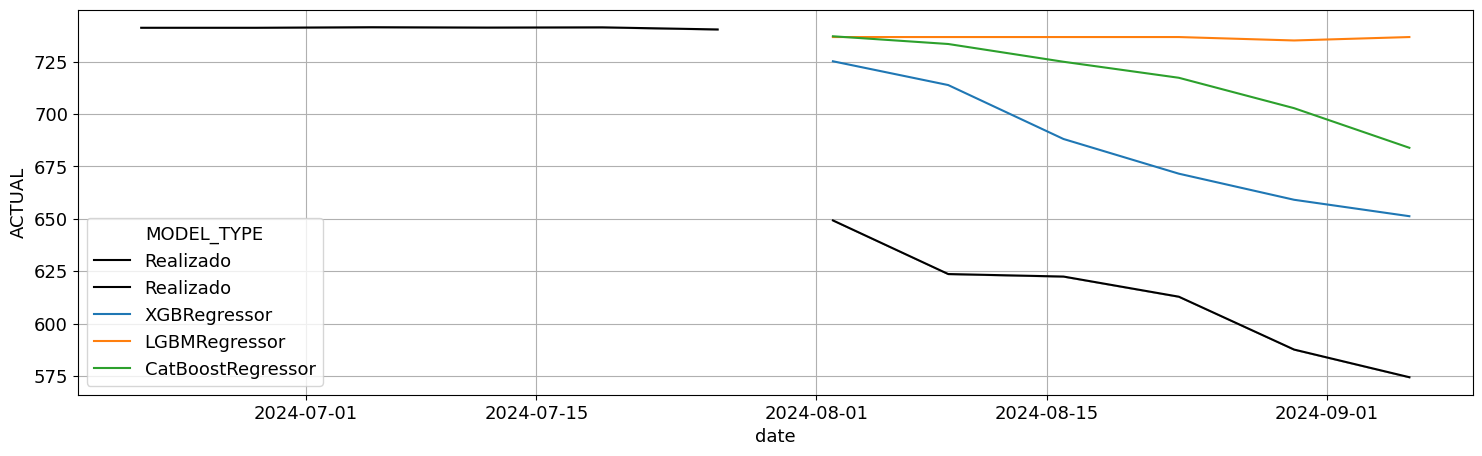

In [75]:
fig, axs = plt.subplots(figsize=(18, 5))
sns.lineplot(data=past_df, x="date", y="ACTUAL", label="Realizado", color="black")
sns.lineplot(data=val_df_window, x="date", y="ACTUAL", label="Realizado", color="black")

sns.lineplot(data=val_df_window, x="date", y="FORECAST", hue="MODEL_TYPE")

plt.grid()
plt.show()

### 8.1 Normalizando as features para olhar as curvas no mesmo gráfico

In [76]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

In [77]:
features = processed_df.drop(columns=["date"]).columns
processed_df_scaled = processed_df.copy()
processed_df_scaled[features] = scaler.fit_transform(processed_df_scaled[features])
processed_df_scaled = processed_df_scaled.set_index("date")

features_train = X_train.drop(columns=["date"]).columns
X_train_scaled = X_train.copy()
X_train_scaled[features_train] = scaler.fit_transform(X_train_scaled[features_train])
X_train_scaled = X_train_scaled.set_index("date")

features_test = X_test_analysis.drop(columns=["MODEL_TYPE", "WINDOW"]).columns
X_test_analysis_scaled = X_test_analysis.copy()
X_test_analysis_scaled[features_test] = scaler.fit_transform(
    X_test_analysis_scaled[features_test]
)
# X_test_analysis_scaled = X_test_analysis_scaled.set_index('date')

### 8.2 Analisando as features no momento da previsão
Incluindo valor real da feature vs valor previsto

#### 8.2.1 Analisando especificamente as variáveis que necessitam de previsão (Lag < 6)

In [78]:
predicted_vars = [
    "sci_market_price_rmbt_lag_2",
    "resale_bhkp_usd_lag_3",
    "oi_invoice_volume_lag_0",
]

In [79]:
fig1 = px.line(
    X_test_analysis_scaled,
    x=X_test_analysis_scaled.index,
    y=["pix_china_bhkp_net_usdt", *predicted_vars],
    title="Predicted Features Analysis - Analysing the August window (worst forecast)",
    markers=True,
    color_discrete_sequence=colors,
)
fig1.update_layout(xaxis_title="Date", yaxis_title="Current Values analysis")

fig1.show()

In [80]:
X_real, y_real = (
    processed_df.set_index("date").drop(columns=[TARGET_COL]),
    processed_df.set_index("date")[TARGET_COL],
)

In [81]:
from src.features.feat_eng import build_features

real_df = prepare_data_for_model(X_real, y_real)

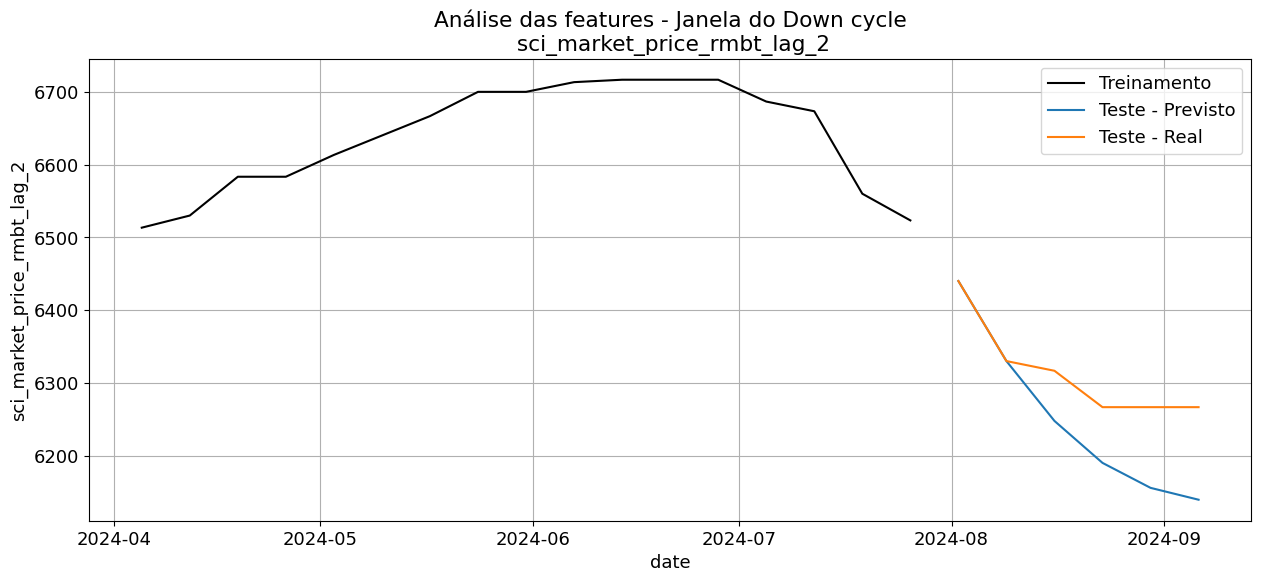

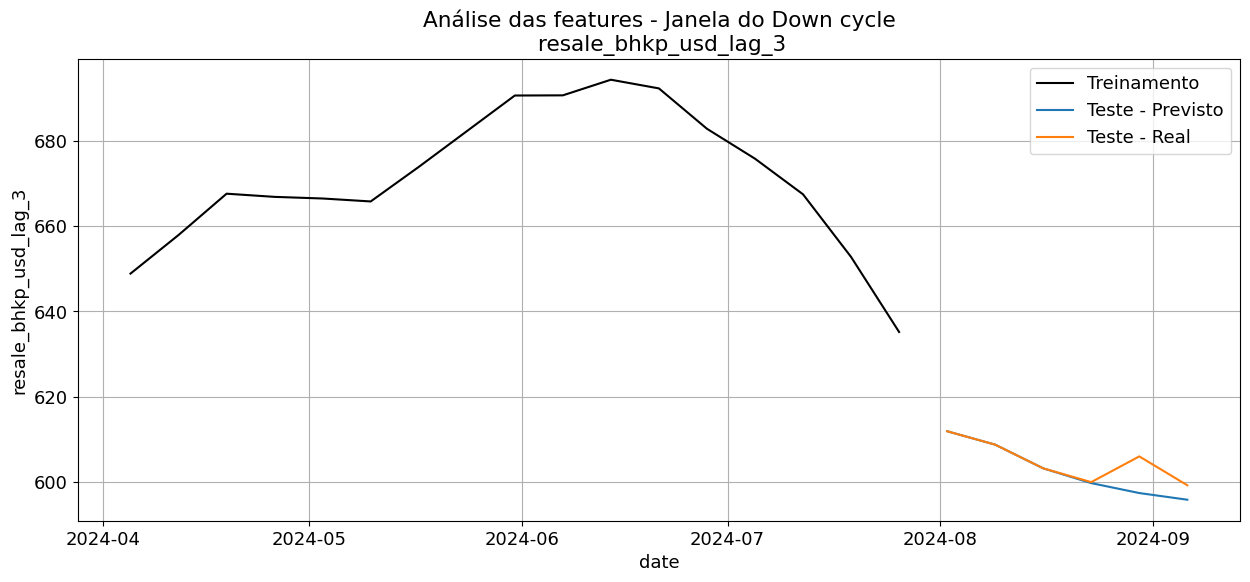

ValueError: Could not interpret value `oi_invoice_volume_lag_0` for `y`. An entry with this name does not appear in `data`.

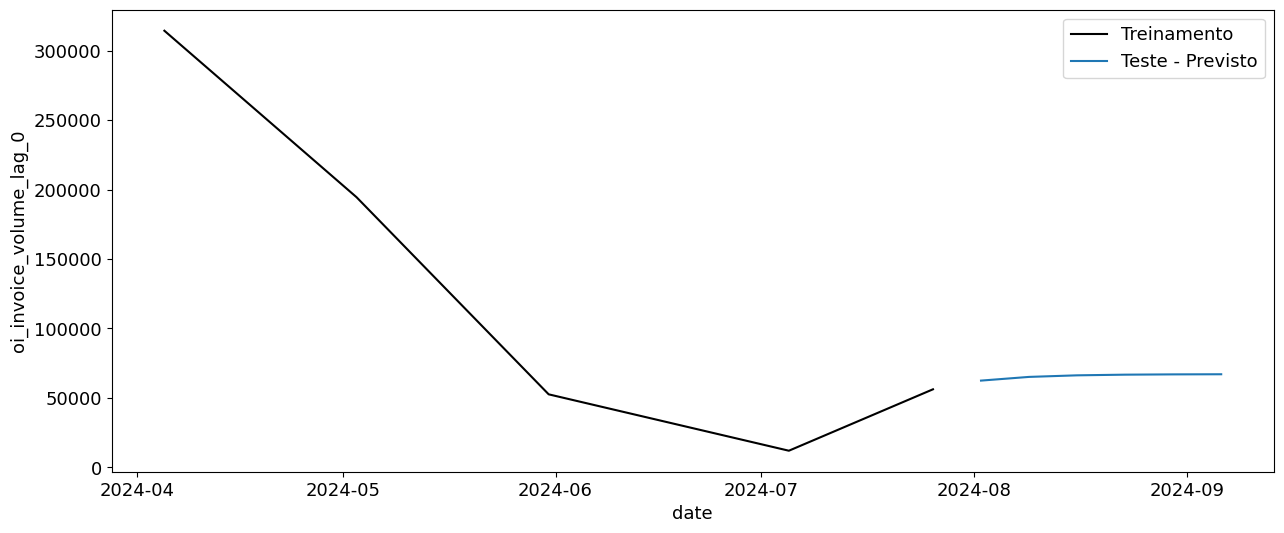

In [82]:
for var in predicted_vars:

    # var = 'oi_invoice_volume_lag_0'

    fig, axs = plt.subplots(figsize=(15, 6))
    sns.lineplot(
        data=X_train[(X_train["WINDOW"] == 14) & (X_train["date"] > "2024-04-01")],
        x="date",
        y=var,
        label="Treinamento",
        color="black",
    )
    sns.lineplot(
        data=X_test_analysis,
        x=X_test_analysis.index,
        y=var,
        label="Teste - Previsto",
    )
    sns.lineplot(
        data=real_df[real_df["date"] >= X_test_analysis.index.min()],
        x="date",
        y=var,
        label="Teste - Real",
    )
    axs.set_title(f"Análise das features - Janela do Down cycle\n {var}")
    plt.legend()
    plt.grid()
    plt.show()

#### 8.2.2 Analisando as variáveis com Lag > 6

In [127]:
not_predicted_vars = [
    "woodchips_imports_lag_6",
    "china_port_inventories_lag_16",
    "china_port_inventories_lag_20",
    "europulp_lag_6",
    "europulp_lag_14",
    "backlog_tons_lag_16",
    "smoothed_moody_24",
]

In [128]:
fig1 = px.line(
    X_test_analysis_scaled,
    x=X_test_analysis_scaled.index,
    y=["pix_china_bhkp_net_usdt", *not_predicted_vars],
    title="Predicted Features Analysis - Analysing the August window (worst forecast)",
    markers=True,
    color_discrete_sequence=colors,
)
fig1.update_layout(xaxis_title="Date", yaxis_title="Current Values analysis")

fig1.show()